In [24]:
import os
import numpy as np
import scipy
from sippy import functionset as fset
import torch.nn.functional as F
import torch

from simba.model import Simba
from simba.functions import identify_baselines, matlab_baselines
from simba.util import print_all_perf, eval_simba, fix_seed, save_results, check_and_initialize_data, print_LS_SIMBa

from simba.parameters import base_parameters, check_parameters
parameters = base_parameters

In [25]:
# Parameters
seed = 12345
n_trajectories_train = 6
trajectories_train = [3]

parameters['max_epochs'] = 100
parameters['init_epochs'] = 100000
parameters['init_from_matlab_or_ls'] = True
parameters['device'] = None
parameters['input_output'] = False

s = ''
for t in trajectories_train:
    s += str(t)
directory = os.path.join('saves', f'Test_{seed}_{s}')

parameters['id_D'] = False
parameters['stable_A'] = True

parameters['batch_size'] = 128
parameters['horizon'] = 10        # Prediction horizon of SIMBa
parameters['stride'] = 1          # Lag between two time steps to start predicting from
parameters['horizon_val'] = None  # None means entire trajectories
parameters['stride_val'] = 1

path_to_matlab = parameters['path_to_matlab']

fix_seed(seed)

In [26]:
# Load and process data as in 
# https://github.com/giorgosmamakoukas/MemoryEfficientStableLDS/blob/master/FrankaLDS/learningLDS/Functions/Psi_x.m

# Simulation
dt = 1/50

N = 399*6 # Separation between train and validation data
H = 399   # Length of each trajectory

data = scipy.io.loadmat('data/FrankaTrainingData')
U_ = data['U'].T
X = data['X'].T
Y = data['Y'].T

# Remove unwanted dimensions for fair comparison
X_ = np.concatenate([X[:3,:], X[6:,:]], axis=0)
Y_ = np.concatenate([Y[:3,:], Y[6:,:]], axis=0)

nx = X_.shape[0]
nu = U_.shape[0]
ny = nx

print(U_.shape, X_.shape, Y_.shape)

(7, 3192) (17, 3192) (17, 3192)


In [27]:
# Prepare the data

# Keep first N elements for training, the rest for validation 
# there are 8 trajectories of 399 steps in the data
U = U_[:,:n_trajectories_train*H]
X = X_[:,:n_trajectories_train*H]
Y = Y_[:,:n_trajectories_train*H]
U_val = U_[:,N:N+H]
X_val = X_[:,N:N+H]
Y_val = Y_[:,N:N+H]
U_test = U_[:,N+H:]
X_test = X_[:,N+H:]
Y_test = Y_[:,N+H:]

ind = np.arange(U.shape[1])
keep = []
for x in trajectories_train:
    keep += [i for i in ind if x*H <= i < (x+1)*H]
U = U[:,keep]
X = X[:,keep]
Y = Y[:,keep]

In [28]:
# Run Unconstrained LS for reference
AB_ls = Y @ np.linalg.pinv(np.concatenate([X, U], axis=0))

A_ls = AB_ls[:,:nx]
B_ls = AB_ls[:,nx:]

# to compare with matlab to ensure the same results are obtained
print(A_ls[:2,:2])
print(f'{np.linalg.norm(Y - A_ls @ X - B_ls @ U, ord="fro")**2 / 2:.2E}')
print(f'{np.linalg.norm(Y_val - A_ls @ X_val - B_ls @ U_val, ord="fro")**2 / 2:.2E}')
print(f'{np.linalg.norm(Y_test - A_ls @ X_test - B_ls @ U_test, ord="fro")**2 / 2:.2E}')

[[ 0.92208081  0.11646841]
 [-0.04623338  1.0290792 ]]
2.66E-01
4.62E+01
1.28E+01


In [12]:
# Prepare the data for SIMBa

# Reshape the data for compatibility with SIMBa, which takes
# (batch_size, time_step, features) as input
U = np.swapaxes(U,0,1)
X = np.swapaxes(X,0,1)
Y = np.swapaxes(Y,0,1)
U_val = np.swapaxes(U_val,0,1)
X_val = np.swapaxes(X_val,0,1)
Y_val = np.swapaxes(Y_val,0,1)
U_test = np.swapaxes(U_test,0,1)
X_test = np.swapaxes(X_test,0,1)
Y_test = np.swapaxes(Y_test,0,1)

# Separate the trajectories and batch them
U = U.reshape(-1, H, nu)
X = X.reshape(-1, H, nx)
Y = Y.reshape(-1, H, ny)
U_val = U_val.reshape(-1, H, nu)
X_val = X_val.reshape(-1, H, nx)
Y_val = Y_val.reshape(-1, H, ny)
U_test = U_test.reshape(-1, H, nu)
X_test = X_test.reshape(-1, H, nx)
Y_test = Y_test.reshape(-1, H, ny)

x0 = X[:,[0],:]
x0_val = X_val[:,[0],:]
x0_test = X_test[:,[0],:]

print(U.shape, X.shape, Y.shape, x0.shape)

# Y is one step ahead for LS but not for IO and SS methods
Y = X
Y_val = X_val
Y_test = X_test

sim_params = (seed, n_trajectories_train, trajectories_train, N, H, dt)
data_params = (parameters['id_D'])
data = (U, U_val, U_test, X, X_val, X_test, Y, Y_val, Y_test, x0, x0_val, x0_test)

(1, 399, 7) (1, 399, 17) (1, 399, 17) (1, 1, 17)


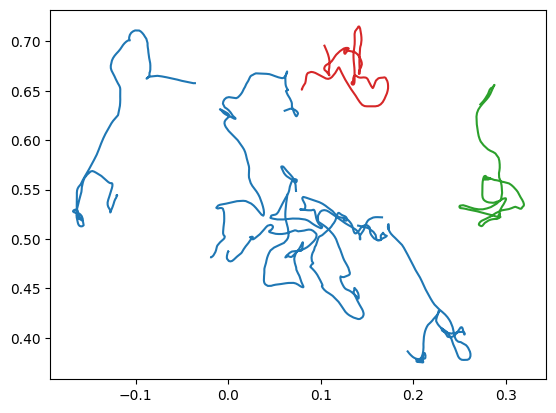

In [7]:
# Plot training data
import matplotlib.pyplot as plt
for i in range(len(trajectories_train)):
    plt.plot(Y[i,:,1], Y[i,:,2], c='tab:blue')
plt.plot(Y_val[0,:,1], Y_val[0,:,2], c='tab:green')
plt.plot(Y_test[0,:,1], Y_test[0,:,2], c='tab:red')

In [8]:
# Evaluate classical sysID baselines
U, U_val, U_test, X, X_val, X_test, Y, Y_val, Y_test, x0, x0_val, x0_test = check_and_initialize_data(U, U_val, U_test, X, X_val, X_test, Y, Y_val, Y_test, x0, x0_val, x0_test,
                                                                                                            verbose=parameters['verbose'], autonomous=parameters['autonomous'], 
                                                                                                            input_output=parameters['input_output'], device=parameters['device'])

names, baselines, times, train_ids, validation_ids, test_ids = [], [], [], [], [], []

In [9]:
# SIMBa
# Standard parameters
parameters['ms_horizon'] = None # No multiple shooting
parameters['learn_x0'] = False
parameters['base_lambda'] = 1

# Tunable parameters
parameters['learning_rate'] = 0.001
parameters['grad_clip'] = 100
parameters['train_loss'] = F.mse_loss
parameters['val_loss'] = F.mse_loss
parameters['dropout'] = 0
parameters['print_each'] = 2500

# Enforce stability
parameters['LMI_A'] = True

# Proposition 2
parameters['delta'] = dt

# Transform to numpy for compatibility
parameters = check_parameters(parameters)
A_ls = torch.tensor(A_ls, dtype=torch.float64, device=parameters['device'])
B_ls = torch.tensor(B_ls, dtype=torch.float64, device=parameters['device'])

for i in range(10):
    name = f'SIMBa_{i+1}'
    simba = Simba(nx=nx, nu=nu, ny=ny, parameters=parameters)
    simba.fit(U, U_val=U_val, U_test=U_test, X=X, X_val=X_val, X_test=X_test, Y=Y, Y_val=Y_val, Y_test=Y_test, x0=x0, x0_val=x0_val, x0_test=x0_test)
    simba.save(directory=directory, save_name=name)

    names, times, train_ids, validation_ids, test_ids = eval_simba(simba, name, names, times, train_ids, validation_ids, test_ids, 
                                                        U, U_val, U_test, X, X_val, X_test, Y, Y_val, Y_test, x0, x0_val, x0_test)
    save_results(directory=directory, save_name='Results', names=names, times=times, train_ids=train_ids, 
                validation_ids=validation_ids, test_ids=test_ids, data=data)

    # Evaluate and compare
    print_LS_SIMBa(A_ls, B_ls, A_simba=simba.A, B_simba=simba.B, U=U, X=X, noise=None,
                   U_val=U_val, X_val=X_val, U_test=U_test, X_test=X_test, print_trajs=False)


Initilization starts, fitting A!
Epoch	Fitting loss
1	1.02E-01


KeyboardInterrupt: 

In [ ]:
print_all_perf(names, times, train_ids, validation_ids, Y, Y_val)

Method		Time		Train Perf	Validation Perf

ARMAX-ILLS	2.04E+00s	2.97E-05	5.00E+31
ARMAX-RLLS	7.76E+00s	8.15E-06	4.55E+10
ARX-ILLS	1.25E+00s	2.98E-05	3.68E-03
ARX-RLLS	1.27E+00s	2.98E-05	3.68E-03
OE-ILLS		6.07E+00s	1.37E-05	7.22E-01
N4SID		1.31E-01s	3.13E-01	9.65E-01
MOESP		1.63E-01s	5.14E-01	6.93E-01
CVA		3.28E-01s	3.19E-01	9.70E-01
PARSIM-K	7.49E+00s	5.08E-01	6.90E-01
SIMBa_1		7.01E-01s	1.47E+00	1.21E+00
SIMBa_2		7.37E-01s	1.19E+00	1.23E+00
SIMBa_3		7.53E-01s	3.83E+00	4.63E+00
SIMBa_4		7.56E-01s	1.49E+00	3.19E+00
SIMBa_5		1.17E+00s	8.99E+00	3.83E+00
SIMBa_6		9.23E-01s	1.83E+00	2.81E+00
SIMBa_7		9.09E-01s	9.79E-01	1.33E+00
SIMBa_8		8.48E-01s	3.13E+00	5.09E+00
SIMBa_9		7.31E-01s	8.26E+00	6.98E+00
SIMBa_10	7.78E-01s	4.92E+00	3.56E+00
